# tensor hub 예시 코드

In [15]:
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import glob
# 그래프의 레이아웃을 조정
from matplotlib import gridspec
# 함수 조작, 확장
import functools
# 훈련된 모델 가져오기 (전이학습, Transfer Learning)
import tensorflow_hub as hub 

In [35]:
# @title 이미지 로드 및 시각화 함수 정의 { display-mode: "form" }

# 이미지를 자르는 함수 정의  
# 멘토님이 crop 이 아니라 압축해서 사용한다고 해서 사용 X
def crop_center(image):
    """이미지의 가운데를 잘라서 정사각형 이미지로 만듭니다."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])  # 가로와 세로 중 작은 길이 선택
    offset_y = max(shape[1] - shape[2], 0) // 2  # 세로 길이가 더 길 경우 상단 및 하단을 자를 양 계산
    offset_x = max(shape[2] - shape[1], 0) // 2  # 가로 길이가 더 길 경우 좌측 및 우측을 자를 양 계산
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape)  # 이미지를 잘라서 정사각형으로 변환
    return image

# 이미지를 로드하고 전처리하는 함수 정의
# 모든 입력에 대한 결과 캐시 저장 > 다시 호출하지않고 이전 결과 반환>  메모리 최적화
#  (@ : 데코레이터 바로 아래 함수만 적용)
@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """이미지를 로드하고 전처리합니다."""
    # 이미지 파일을 로컬로 캐시(저장)
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url) # -128:파일길이제한
    # 이미지를 로드하고 float32 numpy 배열로 변환하고 배치 차원을 추가하며 [0, 1] 범위로 정규화합니다.
    img = tf.io.decode_image(
        tf.io.read_file(image_path),
        channels=3, dtype=tf.float32)[tf.newaxis, ...]  # 이미지를 로드하고 새로운 차원을 추가하여 배치 형식으로 변환
    img = crop_center(img)  # 이미지를 중앙 정렬 및 정사각형으로 자름
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)  # 이미지 크기 조정 및 종횡비 보존
    return img

# 이미지를 표시하는 함수 정의
def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]  # 이미지 크기를 가져와서 리스트로 저장
    w = (image_sizes[0] * 6) // 320  # 이미지의 크기에 따라 그림판 크기를 조절
    plt.figure(figsize=(w * n, w))  # 그림판 크기를 설정
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)  # 그림판을 여러 개의 그리드로 나눔
    for i in range(n):
        plt.subplot(gs[i])  # 그리드 중 하나를 선택
        plt.imshow(images[i][0], aspect='equal')  # 이미지를 표시하고 종횡비를 유지
        plt.axis('off')  # 축을 숨김
        plt.title(titles[i] if len(titles) > i else '')  # 제목을 설정
    plt.show()  # 그림판을 표시


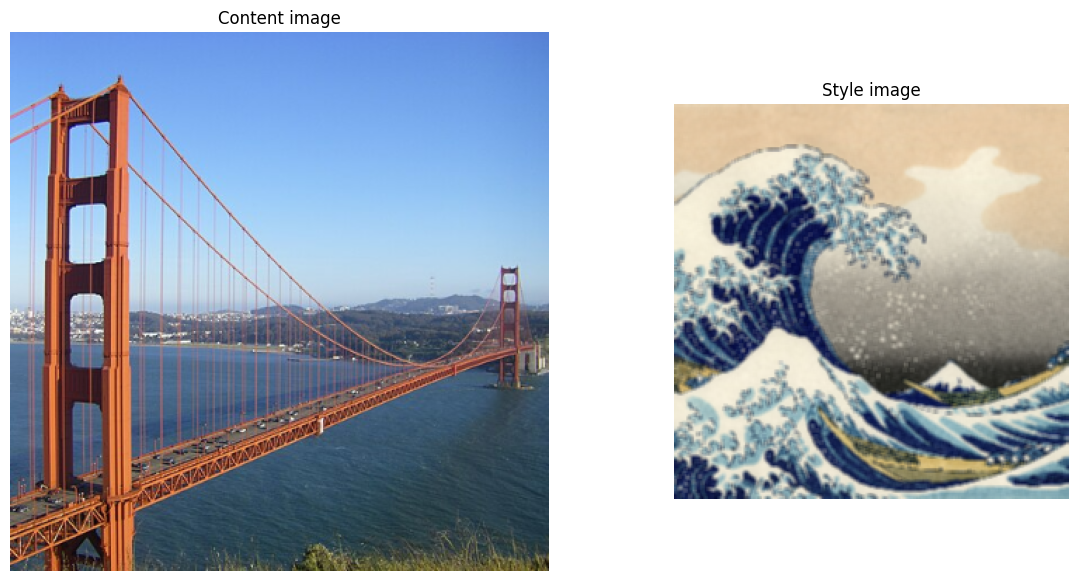

In [36]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# 해당 모델은 스타일 이미지 256 size로 훈련,
content_img_size = (output_image_size, output_image_size)

style_img_size = (256, 256)  # Recommended to keep it at 256. > 그러므로 256 추천함 (근데 난 512했던거 같은데 괜찮았던듯?)

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
# CNN 공부하세요 (괄호안의 내용을 알고 싶다면) 
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [37]:
# tensor hub 에서 모델 가져오기
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [33]:
outputs = hub_module(content_image, style_image) 
stylized_image = outputs[0]  # outputs 첫번째 요소가 스타일 적용된 이미지 (stylized_image)

In [38]:
# 텐서로 변환하여 스타일 적용 (연산시간 차이 거의 없음)
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

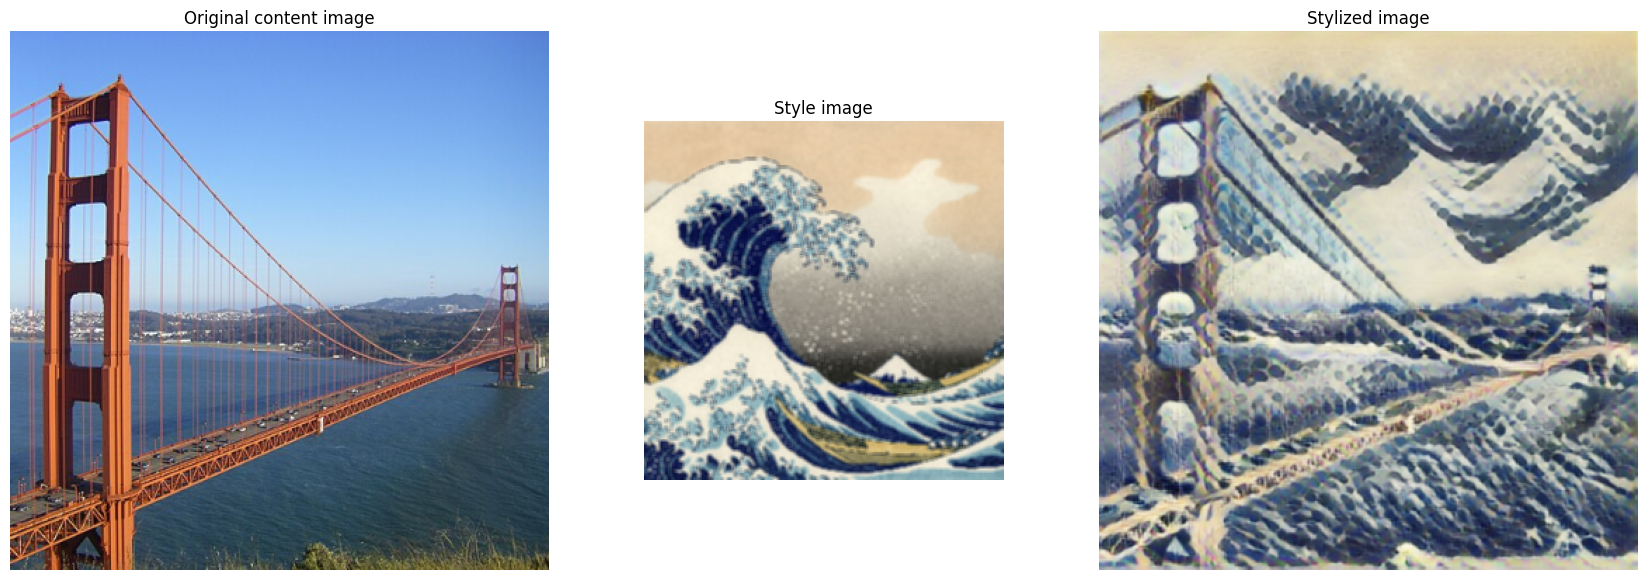

In [39]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# 로컬환경  (여기서부터 수묵화 적용)

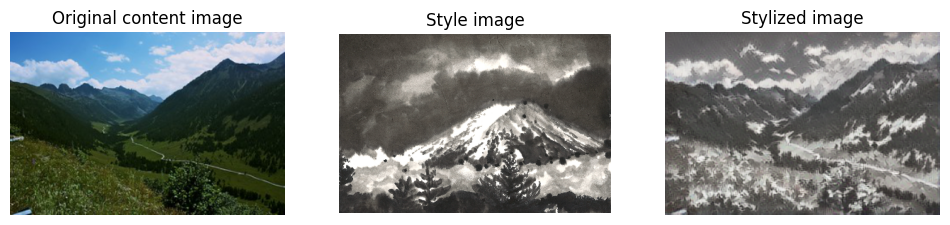

In [48]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import os
import functools
import matplotlib.pyplot as plt
from matplotlib import gridspec


# PIL 통해 사이즈 압축하여 이미지를 로드
# preserve_aspect_ratio 에서 종횡비 유지 여부에 따른 성능차이는 잘 모르겠음
def load_image_from_file(file_path, image_size=(512, 512), preserve_aspect_ratio=True):
    image = PIL.Image.open(file_path)
    image = np.array(image)
    # convert_image_dtype : 타입 변환과 동시에 픽셀값을 0~1 정규화
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 배치크기 1로 설정하여 추가
    image = image[tf.newaxis, ...]
    # image = crop_center(image)   나는 자르지 않고 압축입력함
    image = tf.image.resize(image, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
    return image

# 이미지를 표시하는 함수 정의
def show_n(images, titles=('',)):
    n = len(images)
    # image.shape[0], image.shape[1], image.shape[2] : 세로, 가로, 채널 수 
    image_sizes = [image.shape[1] for image in images]
    # 시각화 크기 계산을 위해 필요
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

# 파일 경로 정의
content_image_path = './datasets/photo/sample1.jpg'
style_image_path = './datasets/style/sample2.jpg'

# 이미지 로드
content_image = load_image_from_file(content_image_path, (384, 384))
style_image = load_image_from_file(style_image_path, (384, 384))

# TensorFlow Hub 모듈 로드
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# 스타일 전이 적용
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

# 시각화
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])


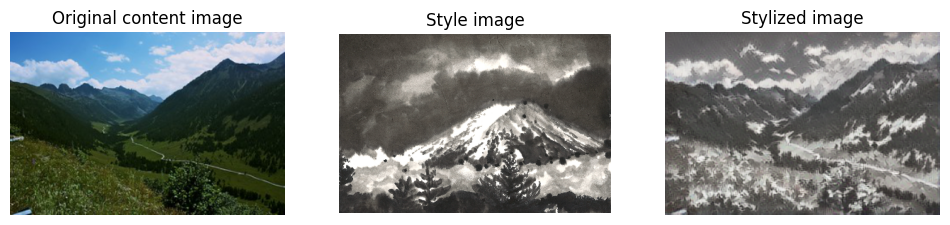

Stylized image saved at: ./result/stylized_image.jpg


In [49]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import os
import functools
import matplotlib.pyplot as plt
from matplotlib import gridspec


# PIL 통해 사이즈 압축하여 이미지를 로드
# preserve_aspect_ratio 에서 종횡비 유지 여부에 따른 성능차이는 잘 모르겠음
def load_image_from_file(file_path, image_size=(512, 512), preserve_aspect_ratio=True):
    image = PIL.Image.open(file_path)
    image = np.array(image)
    # convert_image_dtype : 타입 변환과 동시에 픽셀값을 0~1 정규화
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 배치크기 1로 설정하여 추가
    image = image[tf.newaxis, ...]
    # image = crop_center(image)   나는 자르지 않고 압축입력함
    image = tf.image.resize(image, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
    return image

# 이미지를 표시하는 함수 정의
def show_n(images, titles=('',)):
    n = len(images)
    # image.shape[0], image.shape[1], image.shape[2] : 세로, 가로, 채널 수 
    image_sizes = [image.shape[1] for image in images]
    # 시각화 크기 계산을 위해 필요
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

# 파일 경로 정의
content_image_path = './datasets/photo/sample1.jpg'
style_image_path = './datasets/style/sample2.jpg'

# 이미지 로드
content_image = load_image_from_file(content_image_path, (384, 384))
style_image = load_image_from_file(style_image_path, (384, 384))

# TensorFlow Hub 모듈 로드
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# 스타일 전이 적용
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

# 시각화
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# 파일 저장
output_path = './result/stylized_image.jpg'
# 정규화 수치 > 256 * 256 으로 다시 변환
stylized_image_to_save = tf.image.convert_image_dtype(stylized_image, dtype=tf.uint8)

# stylized_image_to_save = [배치크기, 높이, 너비, 채널] 
# stylized_image_to_save[0] = [높이, 너비, 채널] 
# 호환성을 위해 tensor > numpy 변환
stylized_image_to_save = Image.fromarray(stylized_image_to_save.numpy()[0])
stylized_image_to_save.save(output_path)
print(f"Stylized image saved at: {output_path}")


# 스타일 사진 여러개

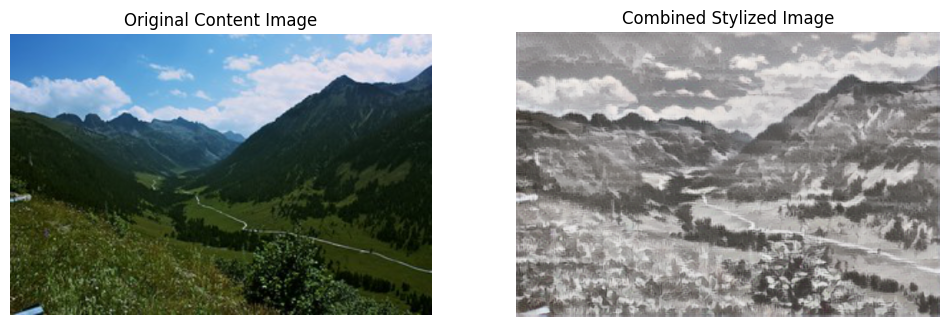

Stylized image saved at: ./result/hap.jpg


In [10]:
# ``` 생략

# 파일 경로 정의
content_image_path = './datasets/photo/sample1.jpg'

# 스타일 이미지들의 경로를 가져옵니다.
style_image_paths = glob.glob('./datasets/style/*.jpg')

# 컨텐츠 이미지를 로드합니다.
content_image = load_image_from_file(content_image_path, (512, 512))

# TensorFlow Hub 모듈을 로드합니다.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# 스타일 전이를 적용하고 각 결과를 리스트에 저장합니다.
stylized_images = []
for style_image_path in style_image_paths:
    style_image = load_image_from_file(style_image_path)
    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    stylized_images.append(stylized_image)

# 모든 스타일 이미지 결과를 평균내어 하나의 이미지로 만듭니다.
combined_stylized_image = tf.reduce_mean(tf.stack(stylized_images), axis=0)

# 최종 결과 시각화
show_n([content_image, combined_stylized_image], titles=['Original Content Image', 'Combined Stylized Image'])

# Save the stylized image
output_path = './result/hap.jpg'
stylized_image_to_save = tf.image.convert_image_dtype(stylized_image, dtype=tf.uint8)
stylized_image_to_save = Image.fromarray(stylized_image_to_save.numpy()[0])

stylized_image_to_save.save(output_path)
print(f"Stylized image saved at: {output_path}")

# content , style 여러개

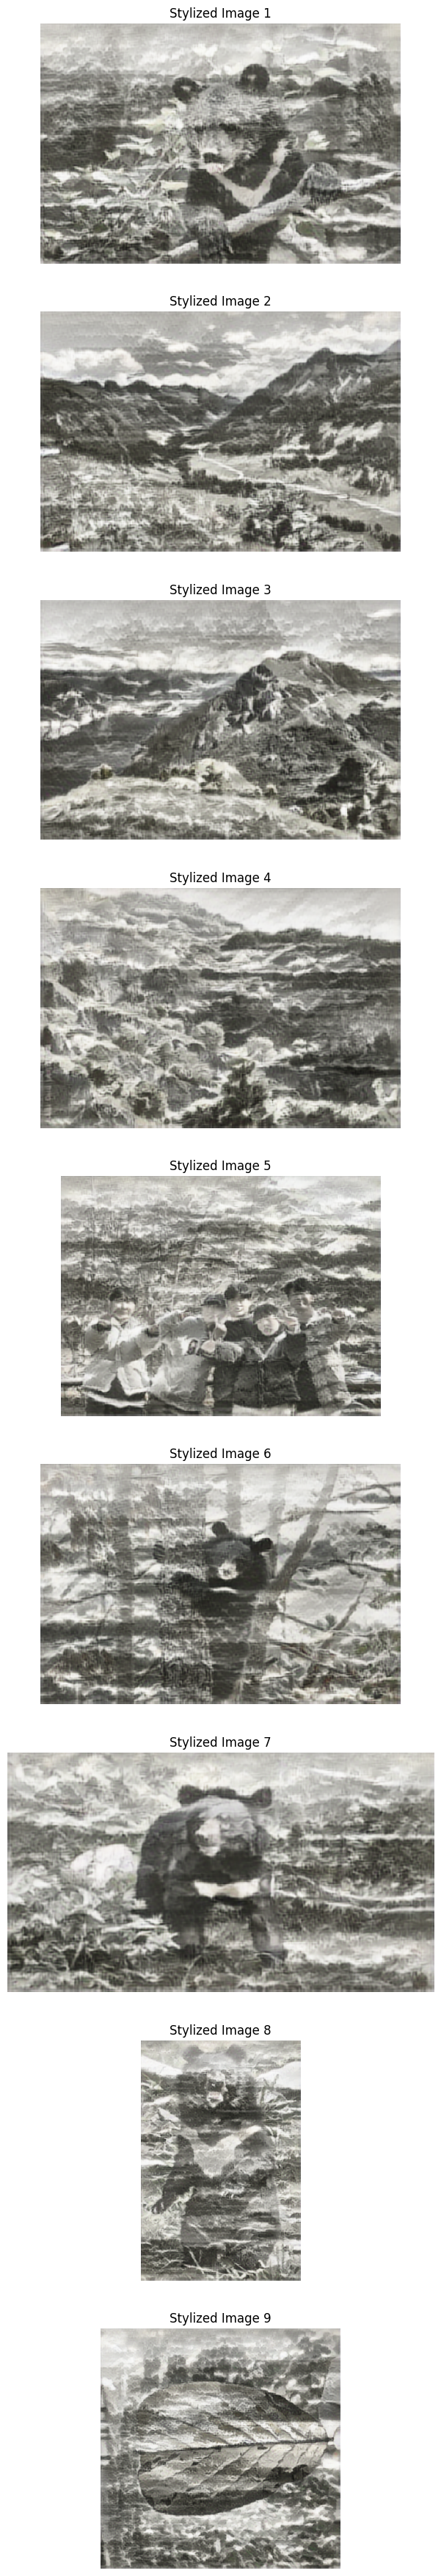

In [11]:
import glob
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import PIL.Image
import os
import functools
import matplotlib.pyplot as plt
from matplotlib import gridspec

# 이미지를 자르는 함수 등의 정의는 생략하고 코드 실행 부분만 제공합니다.

# 컨텐츠 이미지들의 경로를 가져옵니다.
content_image_paths = glob.glob('./datasets/photo/*.jpg')

# 스타일 이미지들의 경로를 가져옵니다.
style_image_paths = glob.glob('./datasets/style/*.jpg')

# TensorFlow Hub 모듈을 로드합니다.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# 모든 컨텐츠 이미지에 대한 최종 스타일링된 이미지를 저장할 리스트를 초기화합니다.
all_stylized_images = []

# 각 컨텐츠 이미지에 대해 스타일 전이를 적용합니다.
for content_image_path in content_image_paths:
    # 컨텐츠 이미지를 로드합니다.
    content_image = load_image_from_file(content_image_path, (384, 384))
    
    # 스타일 전이를 적용하고 각 결과를 리스트에 저장합니다.
    stylized_images = []
    for style_image_path in style_image_paths:
        style_image = load_image_from_file(style_image_path, (256, 256))
        outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
        stylized_image = outputs[0]
        stylized_images.append(stylized_image)
    
    # 모든 스타일 이미지 결과를 평균내어 하나의 이미지로 만듭니다.
    combined_stylized_image = tf.reduce_mean(tf.stack(stylized_images), axis=0)
    # 여러이미지 리스트화
    all_stylized_images.append(combined_stylized_image)

# 시각화 함수에 전체 스타일링된 이미지 리스트를 전달합니다.
# show_n(all_stylized_images, titles=['Combined Stylized Image {}'.format(i+1) for i in range(len(all_stylized_images))])

# 여러개 한번에 보려고 수직으로 보는 코드 작성
def show_images_vertically(images, titles):
    n = len(images)
    plt.figure(figsize=(10, 5 * n))  # 가로 10인치, 세로는 이미지 수에 비례하여 조정
    for i, image in enumerate(images):
        plt.subplot(n, 1, i + 1)  # n개의 행과 1개의 열
        plt.imshow(image[0])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# 시각화 함수에 전체 스타일링된 이미지 리스트를 전달합니다.
show_images_vertically(all_stylized_images, titles=['Stylized Image {}'.format(i+1) for i in range(len(all_stylized_images))])

# 내맘대로 테스트 (무시하세요)

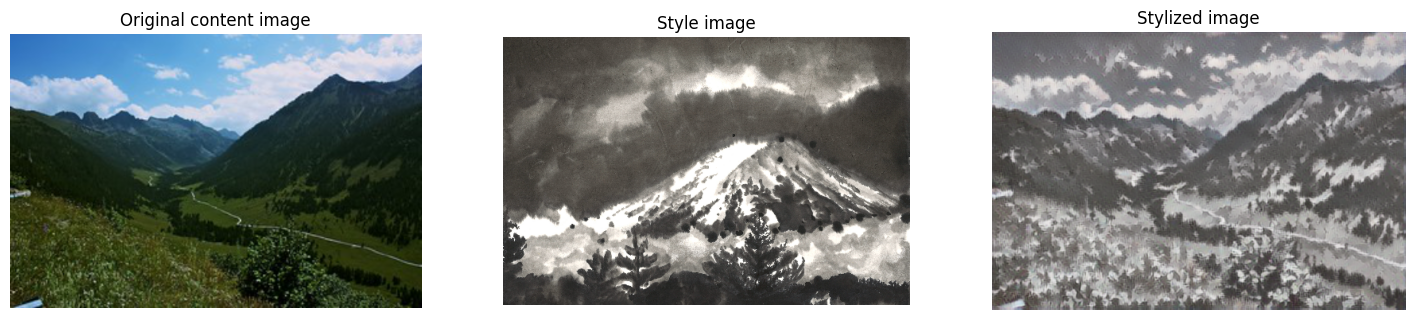

Stylized image saved at: ./result/tree.jpg


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Function to load an image from file
def load_image_from_file(file_path, image_size=(512, 512), preserve_aspect_ratio=True):
    image = Image.open(file_path)
    image = np.array(image)
    # Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis, ...]
    image = tf.image.resize(image, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
    return image

# Function to display images
def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

# Define file paths
content_image_path = './datasets/photo/sample1.jpg'
style_image_path = './datasets/style/sample2.jpg'

# Load images
content_image = load_image_from_file(content_image_path)
style_image = load_image_from_file(style_image_path)

# Load TensorFlow Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# Apply style transfer
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

# Visualize
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# Save the stylized image
output_path = './result/tree.jpg'
stylized_image_to_save = tf.image.convert_image_dtype(stylized_image, dtype=tf.uint8)
stylized_image_to_save = Image.fromarray(stylized_image_to_save.numpy()[0])

stylized_image_to_save.save(output_path)
print(f"Stylized image saved at: {output_path}")


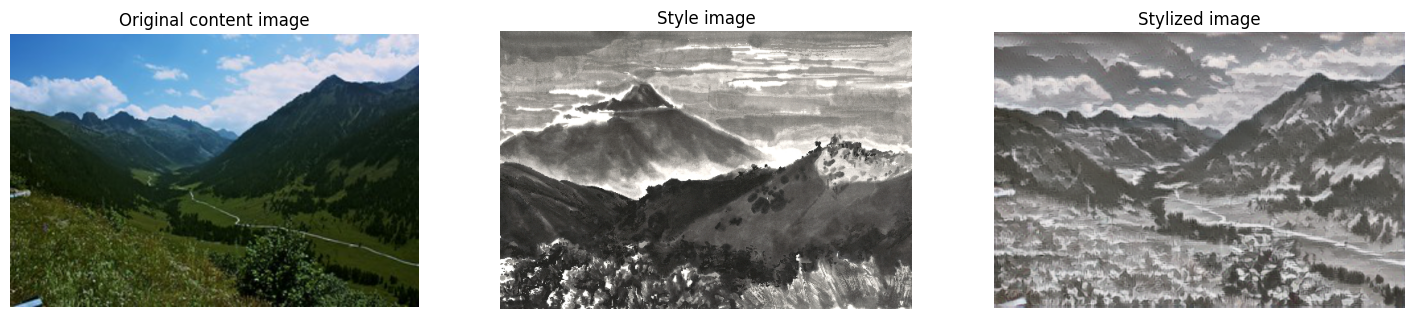

Stylized image saved at: ./result/mountain.jpg


In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Function to load an image from file
def load_image_from_file(file_path, image_size=(512, 512), preserve_aspect_ratio=True):
    image = Image.open(file_path)
    image = np.array(image)
    # Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[tf.newaxis, ...]
    image = tf.image.resize(image, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
    return image

# Function to display images
def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

# Define file paths
content_image_path = './datasets/photo/sample1.jpg'
style_image_path = './datasets/style/sample.jpg'

# Load images
content_image = load_image_from_file(content_image_path)
style_image = load_image_from_file(style_image_path)

# Load TensorFlow Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# Apply style transfer
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

# Visualize
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

# Save the stylized image
output_path = './result/mountain.jpg'
stylized_image_to_save = tf.image.convert_image_dtype(stylized_image, dtype=tf.uint8)
stylized_image_to_save = Image.fromarray(stylized_image_to_save.numpy()[0])

stylized_image_to_save.save(output_path)
print(f"Stylized image saved at: {output_path}")
